This notebook is for prototyping subnetwork flow.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

# torch.set_grad_enabled(False)

### Load models

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

In [5]:
prompt = "The capital of Germany is"

mtf_test = PerTokenMaskedTransformer(
    tl_model, base_prompt=prompt, noise_std=0.2
)
print([n for n, p in mtf_test.named_parameters() if p.requires_grad])
with torch.no_grad():
    for name, mask in mtf_test.masks.items():
        if name == "31_mlp_out" or name == "31_attn_pattern":
            print(name, mask.shape)
            continue
        mask *= 0

with torch.no_grad():
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )
    mtf_test.masks_active = False
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )

['masks.0_attn_z', 'masks.0_attn_pattern', 'masks.0_attn_out', 'masks.0_mlp_out', 'masks.1_attn_z', 'masks.1_attn_pattern', 'masks.1_attn_out', 'masks.1_mlp_out', 'masks.2_attn_z', 'masks.2_attn_pattern', 'masks.2_attn_out', 'masks.2_mlp_out', 'masks.3_attn_z', 'masks.3_attn_pattern', 'masks.3_attn_out', 'masks.3_mlp_out', 'masks.4_attn_z', 'masks.4_attn_pattern', 'masks.4_attn_out', 'masks.4_mlp_out', 'masks.5_attn_z', 'masks.5_attn_pattern', 'masks.5_attn_out', 'masks.5_mlp_out', 'masks.6_attn_z', 'masks.6_attn_pattern', 'masks.6_attn_out', 'masks.6_mlp_out', 'masks.7_attn_z', 'masks.7_attn_pattern', 'masks.7_attn_out', 'masks.7_mlp_out', 'masks.8_attn_z', 'masks.8_attn_pattern', 'masks.8_attn_out', 'masks.8_mlp_out', 'masks.9_attn_z', 'masks.9_attn_pattern', 'masks.9_attn_out', 'masks.9_mlp_out', 'masks.10_attn_z', 'masks.10_attn_pattern', 'masks.10_attn_out', 'masks.10_mlp_out', 'masks.11_attn_z', 'masks.11_attn_pattern', 'masks.11_attn_out', 'masks.11_mlp_out', 'masks.12_attn_z', 

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is are The The of The The The The The The The The of The of The The The The The


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


In [6]:
mtf_test.masks_active = True
with torch.no_grad():
    _, cache = mtf_test.tl_model.run_with_cache(
        prompt,
        remove_batch_dim=True,
    )

assert torch.allclose(cache["resid_pre", 2], cache["resid_post", 30])
assert not torch.allclose(cache["resid_pre", 2], cache["resid_post", 31])
assert torch.allclose(cache["pattern", 2], cache["pattern", 30])
assert not torch.allclose(cache["pattern", 2], cache["pattern", 31])

### Perform optimization

In [74]:
def plot_metrics(
    mtf: PerTokenMaskedTransformer,
    prompt: str,
    metric_history: list[dict[str]],
):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=mtf.tl_model,
        top_k=5,
        use_kv_cache=False,
        n_continuation_tokens=1,
    )

    df = pd.DataFrame(metric_history)

    plt.figure(figsize=(13, 2.7))
    plt.subplot(1, 3, 1)
    df.mean_target_prob.plot()
    plt.legend()
    plt.xlabel("Step")

    plt.subplot(1, 3, 2)
    df.mask_p_norm.plot()
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Step")

    plt.subplot(1, 3, 3)
    df.mask_nonzero.plot()
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Step")

In [85]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>

Complete the statement. {question} [/INST] \
"""


question = "Lionel Messi plays the sport of"
prompt = get_corr_prompt(question, correct=True)

mtf = PerTokenMaskedTransformer(
    tl_model,
    base_prompt=prompt,
)

print(prompt)
correct_token, correct_str = utils.get_top_responses(
    prompt=prompt,
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
)
print(correct_token, correct_str)

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statement. Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 25.85 Prob: 91.49% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 23.41 Prob:  7.95% Tokens: (18993) |Soccer|</s>|
Rank 2. Logit: 20.22 Prob:  0.33% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 19.07 Prob:  0.10% Tokens: ( 7527) |Foot|bal|</s>|
Rank 4. Logit: 18.29 Prob:  0.05% Tokens: (13440) |Foot|ball|</s>|
8914 Football


In [86]:
prompt_tokens = tl_model.to_tokens(prompt)
optim = torch.optim.Adam(
    mtf.masks.parameters(),
    lr=1e-2,
)

alpha = 1
n_steps = 600
p_norm = 1
mtf.noise_std = 0.42
batch_size = 1
torch.random.manual_seed(42)

prompt_tokens_batched = einops.repeat(
    prompt_tokens, "1 ... -> b ...", b=batch_size
).clone()

mtf.train()
metric_history: list[dict[str]] = []
pbar = tqdm(range(n_steps))
for i in pbar:
    logits = mtf.tl_model.forward(
        prompt_tokens_batched,
        return_type="logits",
    )[:, -1]

    target_log_probs = torch.log_softmax(logits, dim=-1)[:, correct_token]
    mean_target_log_prob = target_log_probs.mean()

    mask_p_norm = sum(
        (mask**p_norm).sum() for mask in mtf.masks.values()
    ) ** (1 / p_norm)
    mask_nonzero = sum((mask > 0).sum() for mask in mtf.masks.values())
    mask_numel = sum(mask.numel() for mask in mtf.masks.values())
    density = mask_nonzero / mask_numel
    scaled_p_norm = alpha * i / n_steps / 2 *  mask_p_norm

    loss = -target_log_probs.mean() + scaled_p_norm
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Clamp the masks to be between 0 and 1
    with torch.no_grad():
        for mask in mtf.masks.values():
            mask.clamp_(0, 1)

    metrics = dict(
        step=i,
        loss=loss.item(),
        mean_target_log_prob=mean_target_log_prob.item(),
        mean_target_prob=torch.exp(mean_target_log_prob).item(),
        scaled_p_norm=scaled_p_norm.item(),
        mask_p_norm=mask_p_norm.item(),
        mask_nonzero=mask_nonzero.item(),
        mask_numel=mask_numel,
        density=density.item(),
    )
    metric_history.append(metrics)

    pbar.set_postfix(metrics)

  0%|          | 0/600 [00:00<?, ?it/s]

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Complete the statement. Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 19.47 Prob: 60.47% Tokens: ( 5733) |football|ss|
Rank 1. Logit: 18.85 Prob: 32.38% Tokens: ( 8914) |Football|ss|
Rank 2. Logit: 16.90 Prob:  4.60% Tokens: (20012) |football|ss|
Rank 3. Logit: 14.90 Prob:  0.63% Tokens: (11953) |occer|ss|
Rank 4. Logit: 14.57 Prob:  0.45% Tokens: ( 7604) |visual|att|


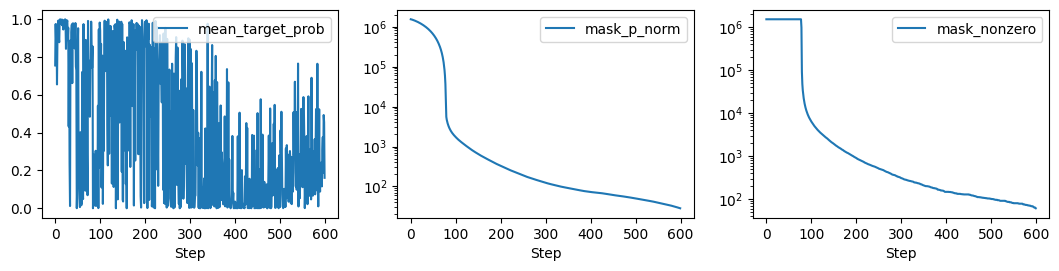

In [87]:
mtf.eval()
plot_metrics(mtf, prompt, metric_history)

### Visualize remaining flow

In [88]:
attn_mask = np.stack(
    [mtf.masks[f"{i}_attn_out"].detach().cpu().numpy() for i in range(32)]
)
attn_z_mask = np.stack(
    [mtf.masks[f"{i}_attn_z"].detach().cpu().numpy() for i in range(32)], axis=0
)
attn_pattern_mask = np.stack(
    [mtf.masks[f"{i}_attn_pattern"].detach().cpu().numpy() for i in range(32)],
)
mlp_mask = np.stack(
    [mtf.masks[f"{i}_mlp_out"].detach().cpu().numpy() for i in range(32)]
)

attn_z_mask *= (attn_mask > 0)[:, :, np.newaxis]
attn_mask.shape, attn_z_mask.shape, attn_pattern_mask.shape, mlp_mask.shape

((32, 53), (32, 53, 32), (32, 32, 53, 53), (32, 53))

<s>|[|INST|]|<<|SY|S|>>|
|You|are|an|assistant|who|only|respond|s|with|a|single|word|.|You|only|give|correct|answers|.|
|<|</|SY|S|>>|
|
|Complete|the|statement|.|Lion|el|Mess|i|plays|the|sport|of|[|/|INST|]|
Layer 0, head 25, token 52: weight=0.47573692
Layer 1, head 24, token 43: weight=0.7139369
Layer 4, head 8, token 52: weight=0.9473411
Layer 4, head 27, token 52: weight=0.1599074
Layer 5, head 26, token 20: weight=0.193688
Layer 5, head 31, token 43: weight=0.86393195
Layer 10, head 4, token 52: weight=0.13324006
Layer 12, head 26, token 52: weight=0.074856654
Layer 12, head 27, token 52: weight=0.33091903
Layer 15, head 17, token 52: weight=0.64358217
Layer 15, head 22, token 52: weight=0.30489826
Layer 16, head 10, token 52: weight=0.8024657
Layer 20, head 5, token 52: weight=0.66915303
Layer 21, head 31, token 52: weight=0.78265244
Layer 31, head 27, token 52: weight=0.96729314
Layer 0, head 25, token_q 52 () token_k 52 (): weight=0.6246142
Layer 1, head 24, token_q 43 (i) tok

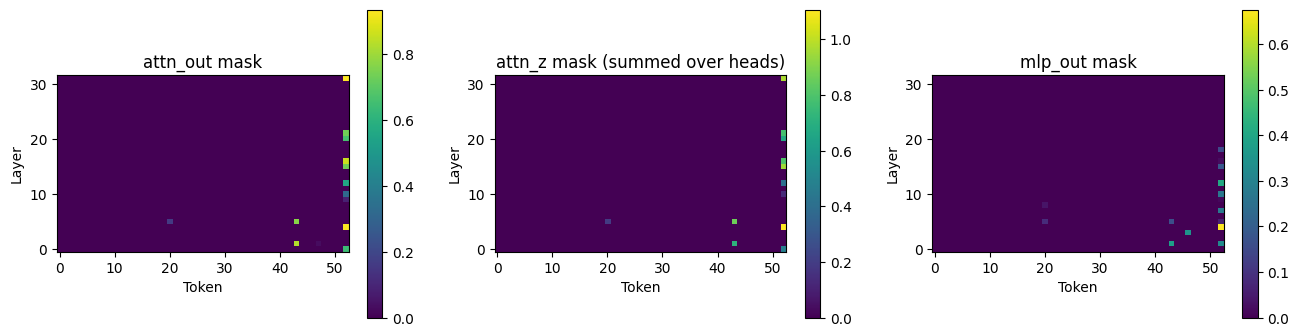

In [89]:
# Plot heatmap of attention mask
subtokens = mtf.tl_model.to_tokens(prompt)[0, mtf.mask_start_idx :]
tokenized_subprompt = "|".join(mtf.tl_model.to_string(x) for x in subtokens)
print(tokenized_subprompt)

for layer_idx in range(32):
    for token_idx in range(mtf.n_tokens):
        for head_idx in range(mtf.tl_model.cfg.n_heads):
            weight = attn_z_mask[layer_idx, token_idx, head_idx]
            if weight > 0:
                print(
                    f"Layer {layer_idx},"
                    f" head {head_idx},"
                    f" token {token_idx}:"
                    f" {weight=}"
                )

for layer_idx in range(32):
    for head_idx in range(mtf.tl_model.cfg.n_heads):
        for token_idx_q in range(mtf.n_tokens):
            for token_idx_k in range(mtf.n_tokens):
                weight = attn_pattern_mask[
                    layer_idx, head_idx, token_idx_q, token_idx_k
                ]
                if weight > 0:
                    q_token = mtf.tl_model.to_string(subtokens[token_idx_q])
                    k_token = mtf.tl_model.to_string(subtokens[token_idx_k])
                    print(
                        f"Layer {layer_idx},"
                        f" head {head_idx},"
                        f" token_q {token_idx_q} ({q_token})"
                        f" token_k {token_idx_k} ({k_token}):"
                        f" {weight=}"
                    )

plt.figure(figsize=(16, 4))
# plt.suptitle(tokenized_subprompt)

plt.subplot(1, 3, 1)
plt.imshow(attn_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_out mask")

plt.subplot(1, 3, 2)
plt.imshow(attn_z_mask.sum(axis=-1), origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_z mask (summed over heads)")

plt.subplot(1, 3, 3)
plt.imshow(mlp_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("mlp_out mask")

plt.show()

### Analyze thresholding

In [90]:
all_mask_values = (
    torch.cat([mask.flatten() for mask in mtf.masks.values()])
    .detach()
    .cpu()
    .numpy()
)

thresholds = np.unique(
    np.sort(np.concatenate([all_mask_values, np.array([0, 1])]))
)
thresh_metrics = []
for thresh in tqdm(thresholds):
    mtf.zero_threshold = thresh
    mtf.one_threshold = 1
    with torch.no_grad():
        target_prob_0 = mtf.tl_model.forward(
            prompt_tokens, return_type="logits"
        )[0, -1].softmax(dim=0)[correct_token]

    mtf.zero_threshold = 0
    mtf.one_threshold = max(thresh, 1e-9)
    with torch.no_grad():
        target_prob_1 = mtf.tl_model.forward(
            prompt_tokens, return_type="logits"
        )[0, -1].softmax(dim=0)[correct_token]

    thresh_metrics.append(
        dict(
            threshold=thresh,
            target_prob_0=target_prob_0.item(),
            target_prob_1=target_prob_1.item(),
            n_nonzero=(all_mask_values > thresh).sum(),
            n_ones=(all_mask_values > thresh).sum(),
        )
    )

  0%|          | 0/62 [00:00<?, ?it/s]

# nonzero mask values: 60
# total mask values: 2934080


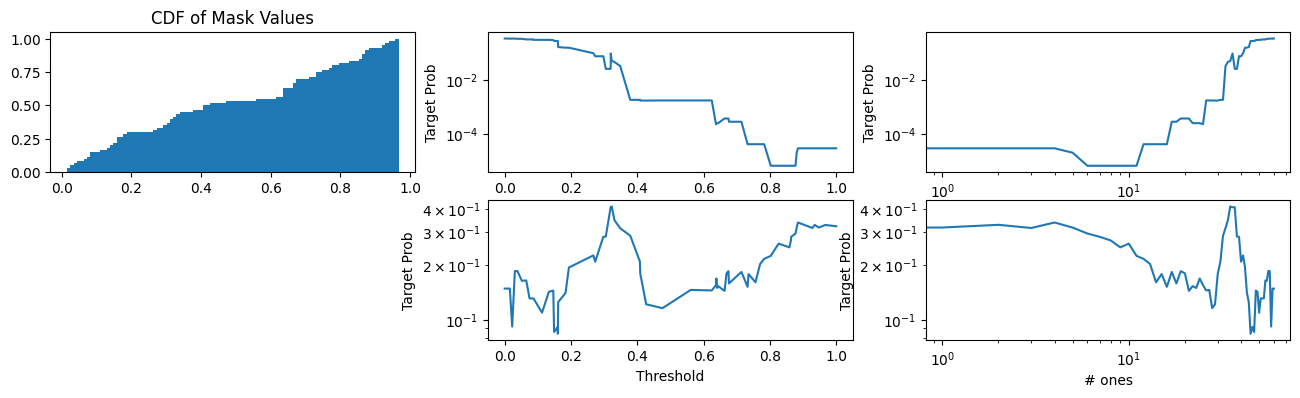

In [91]:
df_thresh = pd.DataFrame(thresh_metrics)

print("# nonzero mask values:", (all_mask_values > 0).sum())
print("# total mask values:", all_mask_values.size)

plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.hist(
    all_mask_values[all_mask_values > 0],
    cumulative=True,
    bins=100,
    density=True,
)
plt.title("CDF of Mask Values")

plt.subplot(2, 3, 2)
plt.plot(df_thresh.threshold, df_thresh.target_prob_0)
plt.yscale("log")
plt.xlabel("0 Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 3)
plt.plot(df_thresh.n_nonzero, df_thresh.target_prob_0)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# non-zero mask values")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 5)
plt.plot(df_thresh.threshold, df_thresh.target_prob_1)
plt.yscale("log")
plt.xlabel("Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 6)
plt.plot(df_thresh.n_ones, df_thresh.target_prob_1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# ones")
plt.ylabel("Target Prob")
plt.show()